<a href="https://colab.research.google.com/github/patrikrac/NLP_SQuAD2.0/blob/main/ATML_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Topics in Machine Learning - Natural Language Processing -- Group Assignment
> Students:
> - Patrik Rác
> - Méline Trochon
> - Valentina Moretti
> - Mattia Colbertaldo

---



In this notebook we:

* investigate the dataset and calculate and visualise statistics for the collection.

* finetune a pretrained DistilBERT model (from HuggingFace's transformers library) on the Squadv2 dataset for question answering.

* train a Word2Vec embedding on the documents and investigate its properties.

* evaluate the model on the test set and save the model and the tokenizer for later use.

* create a chatbot that uses the model to answer questions about the dataset.

* repeat the process using the fine tuned Distilbert on SquadV2 dataset with a pre-indexed Wikipedia dataset.

* implement few shot learning by using a T5 generative model.

* create a chatbot pipeline uning the generative model and few shot learning.

* repeat the last point using a pre-indexed Wikipedia dataset.

* implement text to speech and speech to text to make the chatbot more interactive.

* fine tune whisper to make speech to text work better on our voice

* clone our voice and make the TTS talk with our voice

* create an UI to interact with the chatbot




This notebook is designed to be run on a the SquadV2 dataset.

The preprocessing steps of the dataset used to create the embeddings are custom to the dataset.

In [1]:
! pip install datasets transformers accelerate -U
! pip -q install -U sentence-transformers
! pip install sentencepiece
! pip install --upgrade gensim

!pip -q install hnswlib
! pip install txtai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.2/205.2 kB 4.4 MB/s eta 0:

In [ ]:
!pip install ffmpeg-python
!pip install openai-whisper
!pip install gradio -q
!pip install TTS -q
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=47035c6a060d9bbd871c4894c4e1b46e584c41fd0b7019e91c088182ed213d4d
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

***For smooth executions we recommend to restart the notebook here***.  
The following code should not be run with _Run All_ as the training can be skipped in favor of downloading the already trained models from our Huggingface. Regardless the code for the training is still present in the notebook.

In [1]:
# Imports
import os
import torch
import pandas

import matplotlib.pyplot as plt

from datasets import load_dataset, load_metric

## 1. Investigate Dataset


We will investigate the dataset ***SQuAD2.0 (Stanford Question Answering Dataset)*** avaliable [here](https://rajpurkar.github.io/SQuAD-explorer/).

In [2]:
# Download the dataset
print("Downloading the dataset of SQuAD2.0")
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json

--2024-01-14 17:31:10--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   188MB/s    in 0.2s    

2024-01-14 17:31:12 (188 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



Read the dataset using pandas library from the json file

In [3]:
import pandas
dataframe = pandas.read_json("./train-v2.0.json")
print(f"Size of the dataset: {dataframe.size} (e.g. Categories of questions)")
dataframe.head()

Size of the dataset: 884 (e.g. Categories of questions)


,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


We count the number of paragraphs, questions and impossible questions

In [4]:
def count_paragraphs(row):
    return len(row["data"]["paragraphs"])

print(f"Number of individual paragraphs: {sum(dataframe.apply(count_paragraphs, axis=1))}")


def count_questions(row):
  return sum([len(p["qas"]) for p in row["data"]["paragraphs"]])

print(f"Number of individual questions: {sum(dataframe.apply(count_questions, axis=1))}")

def count_impossible_questions(row):
  n_impossible = 0
  for p in row["data"]["paragraphs"]:
    for q in p["qas"]:
      if q["is_impossible"]:
        n_impossible += 1
  return n_impossible


print(f"Number of impossible questions: {sum(dataframe.apply(count_impossible_questions, axis=1))}")

Number of individual paragraphs: 19035
Number of individual questions: 130319
Number of impossible questions: 43498


Print the dataset

In [5]:
print(type(dataframe.iloc[0]["data"]))

import json
print(json.dumps(dataframe.iloc[1]["data"], sort_keys=False, indent=4))

<class 'dict'>
{
    "title": "Fr\u00e9d\u00e9ric_Chopin",
    "paragraphs": [
        {
            "qas": [
                {
                    "question": "What was Fr\u00e9d\u00e9ric's nationalities?",
                    "id": "56cbd2356d243a140015ed66",
                    "answers": [
                        {
                            "text": "Polish and French",
                            "answer_start": 182
                        }
                    ],
                    "is_impossible": false
                },
                {
                    "question": "In what era was Fr\u00e9d\u00e9ric active in?",
                    "id": "56cbd2356d243a140015ed67",
                    "answers": [
                        {
                            "text": "Romantic era",
                            "answer_start": 276
                        }
                    ],
                    "is_impossible": false
                },
                {
                    "q

Print the example of a Paragraph and a question to understand the structure of the dataset

In [6]:
import textwrap
print("Category of given paragraph: {}\n".format(dataframe.iloc[0]["data"]["title"]))

example_datum = dataframe.iloc[0]["data"]["paragraphs"][0]
print("Context\n {}\n".format(textwrap.fill(example_datum["context"], 50)))

print("Example Question:\n{}\n".format(example_datum["qas"][0]["question"]))

print("Example Answer:\n{}\n".format(example_datum["qas"][0]["answers"][0]["text"]))

Category of given paragraph: Beyoncé

Context
 Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-
YON-say) (born September 4, 1981) is an American
singer, songwriter, record producer and actress.
Born and raised in Houston, Texas, she performed
in various singing and dancing competitions as a
child, and rose to fame in the late 1990s as lead
singer of R&B girl-group Destiny's Child. Managed
by her father, Mathew Knowles, the group became
one of the world's best-selling girl groups of all
time. Their hiatus saw the release of Beyoncé's
debut album, Dangerously in Love (2003), which
established her as a solo artist worldwide, earned
five Grammy Awards and featured the Billboard Hot
100 number-one singles "Crazy in Love" and "Baby
Boy".

Example Question:
When did Beyonce start becoming popular?

Example Answer:
in the late 1990s



We will now create a list with pairs (Title, Question, Paragraph, Answers).

This will be useful for the next steps of the tutorial where we will use the HuggingFace datasets library

In [7]:
data_list = list()
categories = list()
paragraphs = list()
questions = list()

for _, row in dataframe.iterrows():
  categories.append(row["data"]["title"])
  for p in row["data"]["paragraphs"]:
    paragraphs.append(p["context"])
    for q in p["qas"]:
      questions.append(q["question"])
      data_list.append((row["data"]["title"], q, p["context"], q["answers"]))

Plot the number of paragraphs length distribution

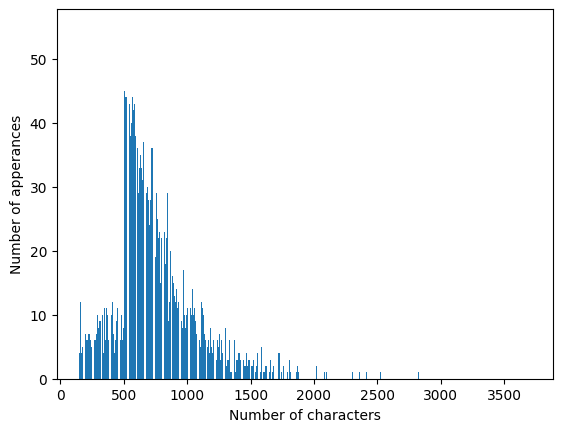

In [8]:
paragraph_len_dict = dict()
for p in paragraphs:
  lp = len(p)
  if lp not in paragraph_len_dict:
    paragraph_len_dict[lp] = 1
  else:
    paragraph_len_dict[lp] += 1

plt.bar(paragraph_len_dict.keys(), paragraph_len_dict.values(), align='center')
plt.xlabel("Number of characters")
plt.ylabel("Number of apperances")
#plt.savefig("len_distribution.png")
plt.show()

## 2. Training Word2Vec

In this section we train a word2vec model on the paragraphs of the SQuAD dataset.

We remove the email addresses and newline characters from the paragraphs and split them into sentences.

In [9]:
# Load the nessecary libraries
import re

# remove newline characters
paragraphs_w2v = [re.sub('\n', ' ', p) for p in paragraphs]
# remove email addresses
paragraphs_w2v = [re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', p) for p in paragraphs_w2v]
# split sentences
paragraph_sentences = [re.split('[?!.]\s', p) for p in paragraphs_w2v]
paragraph_sentences[:3]

[['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
  "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child",
  "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time",
  'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'],
 ['Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar"',
  'Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006)

Flatten the sentences using the flatten function from pandas in order to get a list of sentences

In [10]:
from pandas.core.common import flatten
paragraph_sentences = list(flatten(paragraph_sentences))
paragraph_sentences[:20]

['Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress',
 "Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child",
 "Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time",
 'Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar"',
 'Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and s

We obtain the tokenized sentences of the paragraph by splitting on whitespace, removing punctuation and converting to lowercase

In [11]:
# Preprocess the sentences (very simple tokenization)
paragraph_tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in paragraph_sentences]
# remove sentences that are only 1 word long
paragraph_tokenized_sentences = [sentence for sentence in paragraph_tokenized_sentences if len(sentence) > 1]

for sentence in paragraph_tokenized_sentences[:10]:
    print(sentence)
print()
print(f"Number of tokenized sentences = {len(paragraph_tokenized_sentences)}")

['beyoncé', 'giselle', 'knowles', 'carter', 'biːˈjɒnseɪ', 'bee', 'yon', 'say', 'born', 'september', '4', '1981', 'is', 'an', 'american', 'singer', 'songwriter', 'record', 'producer', 'and', 'actress']
['born', 'and', 'raised', 'in', 'houston', 'texas', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'r', 'b', 'girl', 'group', 'destiny', 's', 'child']
['managed', 'by', 'her', 'father', 'mathew', 'knowles', 'the', 'group', 'became', 'one', 'of', 'the', 'world', 's', 'best', 'selling', 'girl', 'groups', 'of', 'all', 'time']
['their', 'hiatus', 'saw', 'the', 'release', 'of', 'beyoncé', 's', 'debut', 'album', 'dangerously', 'in', 'love', '2003', 'which', 'established', 'her', 'as', 'a', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'awards', 'and', 'featured', 'the', 'billboard', 'hot', '100', 'number', 'one', 'singles', 'crazy', 'in', '

Train the word2vec model on the tokenized sentences.

In [12]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(paragraph_tokenized_sentences, vector_size=30, min_count=5, window=10)

len(model.wv)

23368

### Inspection of the W2V embedding

Now we inspect the word vectors to access if the model is working as expected

In [13]:
term = 'car'
model.wv[term]

array([ 0.46038318, -0.78317565, -0.41701314, -0.01050295, -0.4899384 ,
       -0.4577854 ,  0.3958354 ,  0.58528405, -0.5437419 , -0.51578504,
        1.7429899 , -1.0291944 ,  0.2504216 , -1.1890358 , -0.31292903,
       -0.7693554 , -0.6608475 , -0.02285521, -1.4350383 ,  0.3253315 ,
        0.04603378, -0.52306986,  0.28366715,  0.4295489 , -0.10384667,
       -0.8183313 , -0.0979377 , -1.9910868 ,  0.24693434, -0.783785  ],
      dtype=float32)

As we can see, the closest words to the word 'king' are not really related to the word 'king'.


In [14]:
term = 'king'
model.wv.most_similar(term)

[('emperor', 0.9595262408256531),
 ('henry', 0.9161906242370605),
 ('alexander', 0.9093533754348755),
 ('lord', 0.9063712358474731),
 ('prince', 0.9041572213172913),
 ('son', 0.9032787084579468),
 ('philip', 0.902887225151062),
 ('bishop', 0.9025631546974182),
 ('ruler', 0.9002448916435242),
 ('throne', 0.8965088725090027)]

The operation on the vectors is not givung us the expected result.

In [15]:
vec = model.wv['king'] + (model.wv['woman'] - model.wv['man'])
model.wv.similar_by_vector(vec)

[('king', 0.95528644323349),
 ('philip', 0.9092477560043335),
 ('emperor', 0.9077381491661072),
 ('henry', 0.8906227946281433),
 ('prince', 0.8880877494812012),
 ('alexander', 0.8693663477897644),
 ('kiev', 0.8550514578819275),
 ('bohemia', 0.854141354560852),
 ('mehmed', 0.8522849678993225),
 ('bishop', 0.8494040966033936)]

## 3. Finetuning DistilBERT

In [ ]:
# Import the transformers package (We'll be taking a pretrained model from here)
# !pip install transformers
import transformers
# print(transformers.__version__)

We define the pretrained model we want to use. In this case we are using the _base_ _uncased_ variant of ***DistilBert***. Additionally we are fixing the batch size.

In [ ]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

Load the dataset. Here we can go down two distinct routes that will not have a particularly large impact on the next steps.
1. Use the already prepared ***SQuAD2.0*** dataset from huggingface using the _load_dataset_ method.
2. Transform the prepared data from above into a similar dataset class

The first step is significantly easier and is therefore used, however, even with the second approach there are no major difficulties as the data is already present in a prepared format. We could then just use the already predefined split or use the huggingface funciton _train_test_split()_ in order to split the data.

For the first approach we additionally reduce the size of the training set as we want to achieve the fine tuning in a reasonable time frame. We thus select a random (fixed seed) subset of 20_000 items.

In [ ]:
squad2_datasets = load_dataset("squad_v2") # Possibly replace the huggingface prepared dataset with the custom loaded one...
print(squad2_datasets)
# Reduce the size of the training data set by selecting a random subsample
# squad2_datasets["train"] = squad2_datasets["train"].shuffle(seed=42).select(range(20000))
# print(squad2_datasets)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


We then import the tokenizer that was used to pretrain the given model as we will also use it. For this reason we import the _AutoTokenizer_ class from _transformers_ and use its method _from_pretrained_.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We can now simply test the tokenizer on a sample question/paragrpah and see what happens!

In [ ]:
sample_IDX = 1
switched_vocab = {v: k for k, v in tokenizer.vocab.items()}

# Example with a Question
sample_question = squad2_datasets["train"][sample_IDX]["question"]
print(f"The sample question is: ''{sample_question}''")
print(f"The tokenized question is: {tokenizer(sample_question).input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenizer(sample_question).input_ids])
print()

# Example with a Paragraph
sample_paragraph = squad2_datasets["train"][sample_IDX]["context"]
print(f"The sample context is: ''{sample_paragraph}''")
print(f"The tokenized context is: {tokenizer(sample_paragraph).input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenizer(sample_paragraph).input_ids])
print()

# Complete example (Question + Context)
tokenization_example_complete = tokenizer(sample_question, sample_paragraph)
print(f"The tokenized example is: {tokenization_example_complete.input_ids}")
print('token values: ', [switched_vocab[i] for i in tokenization_example_complete.input_ids])
print()

print("Vocabulary size: ", len(tokenizer.vocab))

The sample question is: ''What areas did Beyonce compete in when she was growing up?''
The tokenized question is: [101, 2054, 2752, 2106, 20773, 5566, 1999, 2043, 2016, 2001, 3652, 2039, 1029, 102]
token values:  ['[CLS]', 'what', 'areas', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?', '[SEP]']

The sample context is: ''Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 nu

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
pad_on_right = tokenizer.padding_side == "right"

Here we prepare the training features.

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

We call the prepare_train_features function on our training dataset

In [ ]:
from datasets import load_dataset
tokenized_datasets = squad2_datasets.map(prepare_train_features, batched=True, remove_columns=squad2_datasets["train"].column_names)

### Actual Fine Tuning of the Model

We use the pretrained model of the huggingface library

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

# model_path = "/content/test-squad-trained_full.zip"
#
# if os.path.exists(model_path):
#  # Unzip the model file
#  ! unzip "/content/test-squad-trained_full"
#  model = AutoModelForQuestionAnswering.from_pretrained("/content/content/test-squad-trained").to(device)
#  print("Loaded the already finetuned model. Do not run the training loop!")
#else:
#  model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to(device)
#  print("Loaded a not finetuned checkpoint of Huggingface. Please run training loop!")
#

model = AutoModelForQuestionAnswering.from_pretrained("patrikrac/test-squad-trained_full").to(device)

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Here we define the metric that we want to use to fine tune the model

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

Data collator is the function that will help us collate the data into batches

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

Here we initialize our Trainer.

We use the pretrained model, the training and validation datasets from squadv2.

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Skip this if the finetuned model is already loaded.  
Jump to the section evaluation!

##### Training (skip in most cases)

We call the train function

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.221600,1.278445
2,0.922400,1.235207
3,0.731500,1.440542


TrainOutput(global_step=24705, training_loss=1.09187263962808, metrics={'train_runtime': 15190.6149, 'train_samples_per_second': 26.02, 'train_steps_per_second': 1.626, 'total_flos': 3.873165421863629e+16, 'train_loss': 1.09187263962808, 'epoch': 3.0})

We save the model

In [ ]:
trainer.save_model("test-squad-trained")

Download the model

In [ ]:
!zip -r /content/test-squad-trained.zip /content/test-squad-trained
from google.colab import files
files.download("/content/test-squad-trained.zip")

  adding: content/test-squad-trained/ (stored 0%)
  adding: content/test-squad-trained/vocab.txt (deflated 53%)
  adding: content/test-squad-trained/tokenizer_config.json (deflated 76%)
  adding: content/test-squad-trained/special_tokens_map.json (deflated 42%)
  adding: content/test-squad-trained/config.json (deflated 44%)
  adding: content/test-squad-trained/tokenizer.json (deflated 71%)
  adding: content/test-squad-trained/training_args.bin (deflated 51%)
  adding: content/test-squad-trained/model.safetensors (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Evaluation
Here we take a batch of data from the validation set and give it to the model. The model will return the predicted start and end positions for each question and context pair and the loss.

In [ ]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

Here we prepare the validation features.

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

We use the map function on the validation dataset to divide it in batches and to remove the columns names.

In [ ]:
validation_features = squad2_datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=squad2_datasets["validation"].column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

We get the raw predictions from our model by calling trainer.predict. This will return predictions on the validation dataset.

In [ ]:
raw_predictions = trainer.predict(validation_features)

We set the correct format by getting the keys (column names) of the features in the dataset and extracting the current format type of the validation_features dataset.

In [ ]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

Here we print in decreasing order the score and the text of the answer for the first question in the validation dataset.

In [ ]:
import numpy as np
n_best_size = 20
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = squad2_datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 15.947659, 'text': 'France'},
 {'score': 9.204634, 'text': 'France.'},
 {'score': 8.549504, 'text': 'a region in France'},
 {'score': 7.7355385,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway'},
 {'score': 7.7185407, 'text': 'in France'},
 {'score': 7.3409142,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark'},
 {'score': 6.6115103, 'text': 'Normandy, a region in France'},
 {'score': 6.412133, 'text': 'region in France'},
 {'score': 6.255315,
  'text': 'France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland'},
 {'score': 4.354934, 'text': ', a region in France'},
 {'score': 4.0010204,
  'text': 'in the 10th and 11th centuries gave their name to Normandy, a region in France'},
 {'score': 3.3682275,
  'text': '10th and 11th centuries gave their name to Normandy, a r

Code for computing the score of the model

In [ ]:
# Code for computing the score of the model

from tqdm.auto import tqdm
import collections

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

postprocess_qa_predictions function takes raw predictions, processes them, and produces the final predictions in a suitable format.

In [ ]:
final_predictions = postprocess_qa_predictions(squad2_datasets["validation"], validation_features, raw_predictions.predictions)

Post-processing 11873 example predictions split into 12134 features.


  0%|          | 0/11873 [00:00<?, ?it/s]

We load the metric associated with squad_v2

In [ ]:
metric = load_metric("squad_v2")

<ipython-input-31-9cd7db57dbcb>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad_v2")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for squad_v2 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad_v2/squad_v2.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


We compute the metric on the validation dataset. We pass to the compute function the list of raw predictions and the list of references.

As result we have :
* exact match accuracy: (https://huggingface.co/spaces/evaluate-metric/exact_match). A given predicted string’s exact match score is 1 if it is the exact same as its reference string, and is 0 otherwise.
The exact match score of a set of predictions is the sum of all of the individual exact match scores in the set, divided by the total number of predictions in the set.

* F1 score: (https://huggingface.co/spaces/evaluate-metric/f1). It is the harmonic mean of the precision and recall. It can be computed with the equation: F1 = 2 * (precision * recall) / (precision + recall). Precision is the ratio of true positives to the sum of true positives and false positives. Recall is the ratio of true positives to the sum of true positives and false negatives.

* Total number of examples on which the evaluation was performed.

In [ ]:
formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]
references = [{"id": ex["id"], "answers": ex["answers"]} for ex in squad2_datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

{'exact': 64.63404362840058,
 'f1': 68.05674567560314,
 'total': 11873,
 'HasAns_exact': 68.4379217273954,
 'HasAns_f1': 75.29314126289378,
 'HasAns_total': 5928,
 'NoAns_exact': 60.841042893187556,
 'NoAns_f1': 60.841042893187556,
 'NoAns_total': 5945,
 'best_exact': 64.63404362840058,
 'best_exact_thresh': 0.0,
 'best_f1': 68.05674567560327,
 'best_f1_thresh': 0.0}


Results from the first fine tuning:  
{'exact': 54.703950138970775,
 'f1': 58.20276713732525,
 'total': 11873,
 'HasAns_exact': 52.02429149797571,
 'HasAns_f1': 59.03195921414672,
 'HasAns_total': 5928,
 'NoAns_exact': 57.37594617325484,
 'NoAns_f1': 57.37594617325484,
 'NoAns_total': 5945,
 'best_exact': 55.08296134085741,
 'best_exact_thresh': 0.0,
 'best_f1': 58.32510565770994,
 'best_f1_thresh': 0.0}

 Results from the second fine tuning:  
 {'exact': 64.63404362840058,
 'f1': 68.05674567560314,
 'total': 11873,
 'HasAns_exact': 68.4379217273954,
 'HasAns_f1': 75.29314126289378,
 'HasAns_total': 5928,
 'NoAns_exact': 60.841042893187556,
 'NoAns_f1': 60.841042893187556,
 'NoAns_total': 5945,
 'best_exact': 64.63404362840058,
 'best_exact_thresh': 0.0,
 'best_f1': 68.05674567560327,
 'best_f1_thresh': 0.0}


## 4. Chat-Bot using the finetuned DistilBERT model

MS MARCO Passage Ranking is a large dataset to train models for information retrieval. It consists of about 500k real search queries from Bing search engine with the relevant text passage that answers the query.

* multi-qa-MiniLM-L6-cos-v1 maps sentences & paragraphs to a 384 dimensional dense vector space and was designed for semantic search. It has been trained on 215M (question, answer) pairs from diverse sources. (https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1)

* cross-encoder/ms-marco-MiniLM-L-6-v2 model can be used for Information Retrieval: Given a query, encode the query with all possible passages (e.g. retrieved with ElasticSearch). Then sort the passages in a decreasing order. (https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2)


In [16]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Now let's embed the paragraphs

(We can checkpoint the embeddings to avoid repeating the computation each time)

In [17]:
import os
import pickle

# Define hnswlib index path
embeddings_cache_path = './qa_embeddings_cache.pkl'

# Load cache if available
if os.path.exists(embeddings_cache_path):
    print('Loading embeddings cache')
    with open(embeddings_cache_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
# Else compute embeddings
else:
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(paragraphs, convert_to_tensor=True, show_progress_bar=True)
    # Save the index to a file for future loading
    print(f'Saving index to: \'{embeddings_cache_path}\'')
    with open(embeddings_cache_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

Computing embeddings


Batches:   0%|          | 0/595 [00:00<?, ?it/s]

Saving index to: './qa_embeddings_cache.pkl'


We can build an ANN index to do a quick cosine similarity search. An ANN index, or Approximate Nearest Neighbors index, is a data structure used for efficient similarity search in high-dimensional spaces. It's designed to find the points in a dataset that are closest to a given point.

Hnswlib is a library for approximate nearest neighbor search used for efficient similarity search in high-dimensional spaces.

We use cosine similarity to initialize the index. For each element in the corpus, hnswlib_index.add_items adds the corpus embeddings and their corresponding indices to the index.

In [18]:
import os
import hnswlib
import time
start = time.time()
# Create empthy index
index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = './qa_hnswlib_100.index'

# Load index if available
if os.path.exists(index_path):
    print('Loading index...')
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print('Start creating HNSWLIB index')
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=100, M=64) # see https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for parameter description
    # Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print(f'Saving index to: {index_path}')
    index.save_index(index_path)

end = time.time()
print(f"Exectution time: {int((end - start) / 60)}:{int((end - start) % 60)} min:sec")

Start creating HNSWLIB index
Saving index to: ./qa_hnswlib_100.index
Exectution time: 0:3 min:sec


Let's pick a random question from the list

In [19]:
import random

random.seed(42)

idx = random.choice(range(len(questions)))

question = questions[idx]

print(f'Question {idx}: {question}?')

Question 83810: What century did Nasser rule in??


We use the sentence embeddings model to encode the questions. We will later use this also to encode the question revieved from the user.

In [20]:
question_embedding = semb_model.encode(question, convert_to_tensor=True)

We use the index to find the k-closest question in the corpus to the question recieved from the user.

In [21]:
corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx, score in zip(corpus_ids[0][:5], scores[0][:5]):
    print(f"Score: {score:.4f}\nDocument: \"{paragraphs[idx]}\"\n\n")

Cosine similarity model search results
Query: "What century did Nasser rule in?"
---------------------------------------
Score: 0.5924
Document: "The national economy grew significantly through agrarian reform, major modernization projects such as the Helwan steel works and the Aswan Dam, and nationalization schemes such as that of the Suez Canal. However, the marked economic growth of the early 1960s took a downturn for the remainder of the decade, only recovering in 1970. Egypt experienced a "golden age" of culture during Nasser's presidency, according to historian Joel Gordon, particularly in film, television, theater, radio, literature, fine arts, comedy, poetry, and music. Egypt under Nasser dominated the Arab world in these fields, producing cultural icons."


Score: 0.5815
Document: "Nasser's nationalization of the Suez Canal and his emergence as the political victor from the subsequent Suez Crisis substantially elevated his popularity in Egypt and the Arab world. Calls for pan-

Re-rank retrieved documents using the cross-encoder. As we can see now we obtain a better result (a document more related to the question).

In [22]:
import numpy as np

# Create model inputs
model_inputs = [(question, paragraphs[i]) for i in corpus_ids[0]]

# Predict scores using the cross-encoder model
cross_scores = xenc_model.predict(model_inputs, show_progress_bar=True)

# Print results
print("Cross-encoder model re-ranking results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:5]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{paragraphs[corpus_ids[0][idx]]}\"\n\n")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Cross-encoder model re-ranking results
Query: "What century did Nasser rule in?"
---------------------------------------
Score: 5.8923
Document: "Nasser remains an iconic figure in the Arab world, particularly for his strides towards social justice and Arab unity, modernization policies, and anti-imperialist efforts. His presidency also encouraged and coincided with an Egyptian cultural boom, and launched large industrial projects, including the Aswan Dam and Helwan City. Nasser's detractors criticize his authoritarianism, his government's human rights violations, his populist relationship with the citizenry, and his failure to establish civil institutions, blaming his legacy for future dictatorial governance in Egypt. Historians describe Nasser as a towering political figure of the Middle East in the 20th century."


Score: 4.9693
Document: "Nasser played a significant part in the strengthening of African solidarity in the late 1950s and early 1960s, although his continental leadershi

### Retrieve the answer through a pipeline

 By using the pipeline of the transformers library we can now retrieve an answer. In this case it is enough to pass the question and the context to the pipeline and it will return the answer with the highest score.

In [23]:
from transformers import pipeline

Let's take the fine-tuned model

In [24]:
tokenizer_checkpoint = "distilbert-base-uncased"
model_checkpoint = "patrikrac/test-squad-trained_full"

This line creates a question-answering pipeline. It is a convenient way to load pre-trained models and use them for specific tasks. "question-answering" specifies the task for which the pipeline will be used.

In [25]:
question_answerer = pipeline("question-answering", model=model_checkpoint, tokenizer = tokenizer_checkpoint)

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

We need to pass to the question-answering pipeline both the question and the context.

Example:

In [26]:
context = """
This annexation was one of the direct causes of the brief and bloody War of the Reunions whose outcome left the French in possession. The French annexation was recognized by the Treaty of Ryswick (1697). The official policy of religious intolerance which drove most Protestants from France after the revocation of the Edict of Nantes in 1685 was not applied in Strasbourg and in Alsace, because both had a special status as a province à l'instar de l'étranger effectif (a kind of foreign province of the king of France). Strasbourg Cathedral, however, was taken from the Lutherans to be returned to the Catholics as the French authorities tried to promote Catholicism wherever they could (some other historic churches remained in Protestant hands). Its language also remained overwhelmingly German: the German Lutheran university persisted until the French Revolution. Famous students included Goethe and Herder.
"""
question = "When did the House of Burgundy issue the Pragmatic Sanction?"
question_answerer(question=question, context=context)

{'score': 9.116825822275132e-05, 'start': 338, 'end': 342, 'answer': '1685'}

#### Response function
Let's define a response function

We use the sentence encoder to encode the question revieved from the user, as we have done before for the corpus questions.

We use the index to find the closest question in the corpus to the question recieved from the user.

We find the best answer in the list using the cross-encoder

We keep the best k paragraphs so that if the cross-encoder model is wrong about the first one, we can still get a good answer

Once we have obtained the top k paragraphs, we can use the question answering model to get the answer. We do this by passing the question and the paragraph to the question answering model and taking the answer with the highest score.

Particular feature:

If the answer's score is too low, the chatbot will adimit that it does not know the answer

In [27]:
def get_paragraphs(semb_model, xenc_model, question, topp):
  """
  Samples the topp most relevant paragraphs for the given quesion embedding
  """
  question_embedding = semb_model.encode(question, convert_to_tensor=True)
  corpus_ids, _ = index.knn_query(question_embedding.cpu(), k=128)

  model_inputs = [(question, paragraphs[idx]) for idx in corpus_ids[0]]
  cross_scores = xenc_model.predict(model_inputs)

  #print("Cross-encoder model re-ranking results")
  #print(f"Query: \"{question}\"")
  #print("---------------------------------------")
  #for idx in np.argsort(-cross_scores)[:topp]:
  #  print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{paragraphs[corpus_ids[0][idx]]}\"\n\n")

  return np.argsort(-cross_scores)[:topp], corpus_ids


def get_response(semb_model, xenc_model, question, topp=3, careful=False):
  candidate_idx, corpus_ids = get_paragraphs(semb_model, xenc_model, question, topp)
  candidate_ans = list()
  for idx in candidate_idx:
    candidate_ans.append(question_answerer(question=question, context=paragraphs[corpus_ids[0][idx]]))

  ans = max(candidate_ans, key= lambda item: item['score'])

  if careful:
    if ans["score"] < 0.5:
      return "I do not know the answer to this question."

  return ans["answer"]


#def get_response(model, tokenizer, semb_model, xenc_model, question, topp=5):
#  # Step 1: Find an appropriate paragraph for the question
#  question_embedding = semb_model.encode(question, convert_to_tensor=True)
#  corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
#
#  model_inputs = [(question, ' '.join(paragraphs[i])) for i in corpus_ids[0][:5]]
#  cross_scores = xenc_model.predict(model_inputs)
#  idx = corpus_ids[0][np.argsort(-cross_scores)[1]]
#
#  # Step 2: Get a response from the model
#  ans = question_answerer(question=question, context=paragraphs[idx])

#  return ans['answer']


In [28]:
q = "Who is the best football player of all time?"
print(f"Question: {q}")
print(get_response(semb_model=semb_model, xenc_model = xenc_model, question=q, careful=False))

Question: Who is the best football player of all time?
Lionel Messi


### Chatbot pipeline
The loop for the chatbot breaks when the user inputs "No" or "No!" or "no" or "no!"

Otherwise it will keep asking for questions and will answer them by calling the get_response function

In [29]:
def chatbot_pipeline(semb_model, xenc_model):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = get_response(semb_model=semb_model, xenc_model = xenc_model, question=q, topp=3, careful=False)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [30]:
chatbot_pipeline(semb_model=semb_model, xenc_model = xenc_model)

Bot:	 Do you have a question for me?

You:	no



### Adding more data

We try to better understand the capabilites of the model by investigation heuristically its performance on another dataset.

txtai is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows (https://neuml.github.io/txtai/).

We will be using the wikipedia embeddings from txtai which are pre-indexed paragraph embeddings from wikipedia articles.

In [31]:
from txtai.embeddings import Embeddings

We load the embeddings from the txtai library

In [32]:
embeddings_wiki = Embeddings()
embeddings_wiki.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

embeddings:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

documents:   0%|          | 0.00/3.24G [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Search for similar sentences to an example question

In [33]:
import json

for x in embeddings_wiki.search("Who is Lebron James", 2):
  print(json.dumps(x, indent=2))

{
  "id": "LeBron James",
  "text": "LeBron Raymone James Sr. ( ; born December 30, 1984) is an American professional basketball player for the Los Angeles Lakers of the National Basketball Association (NBA). Nicknamed \"King James\", he is widely recognized as one of the greatest players in the history of the sport and is often compared to Michael Jordan in debates over the greatest basketball player of all time. He has competed in 10 NBA Finals (with eight consecutive appearances from 2011 to 2018) winning four NBA championships. He also won the inaugural NBA Cup in 2023 with the Lakers, and two Olympic gold medals as a member of the U.S. men's national team.  ",
  "score": 0.8967505693435669
}
{
  "id": "Bryce James",
  "text": "Bryce Maximus James (born June 14, 2007) is an American basketball player. He is the second child of National Basketball Association (NBA) player LeBron James and the younger brother of college basketball player Bronny James. James primarily plays the shooti


To get a response from the model, first we need to find the most relevant paragraphs for the question and then we can use the question answering model to get the answer from the paragraph.

We take the the answer with highest score.

Particular feature:

If the answer's score is too low, the chatbot will adimit that it does not know the answer

In [34]:
def get_paragraphs_wiki(embeddings, question, topp):
  """
  Samples the topp most relevant paragraphs for the given quesion embedding
  """
  res = embeddings.search(question, topp)

  return [x["text"] for x in res]


def get_response_wiki(embeddings, question, topp=5, careful=False):
  candidates = get_paragraphs_wiki(embeddings, question, topp)
  candidate_ans = list()
  for x in candidates:
    candidate_ans.append(question_answerer(question=question, context=x))

  ans = max(candidate_ans, key= lambda item: item['score'])

  if careful:
    if ans["score"] < 0.5:
      return "I do not know the answer to this question."

  return ans["answer"]

### Chatbot pipeline wiki
The loop for the chatbot breaks when the user inputs "No" or "No!" or "no" or "no!"

Otherwise it will keep asking for questions and will answer them by calling the get_response function

In [35]:
def chatbot_pipeline_wiki(embeddings):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = get_response_wiki(embeddings=embeddings, question=q, topp=3, careful=False)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [36]:
chatbot_pipeline_wiki(embeddings=embeddings_wiki)

Bot:	 Do you have a question for me?

You:	no



**Example Dialogue**:  
    
Bot:	 Do you have a question for me?

You:	Where is Paris?

Bot:	 city of Paris, France

Bot:	 Do you have another question for me?

You:	Who is the best football player of all time?

Bot:	 Tom Brady

Bot:	 Do you have another question for me?

You:	Who is the best soccer player of all time?

Bot:	 Rivaldo Vítor Borba Ferreira

Bot:	 Do you have another question for me?

You:	How many people attend USI?

Bot:	 9,750

Bot:	 Do you have another question for me?

You:	What is the name of the university of Lugano?

Bot:	 University of Human Sciences and Technology

Bot:	 Do you have another question for me?

You:	How many people live in switzerland?

Bot:	 194,500

Bot:	 Do you have another question for me?

You:	Where is Normandy located?

Bot:	 Colleville-sur-Mer

Bot:	 Do you have another question for me?

You:	Where is the european central bank?

Bot:	 Frankfurt, Germany

Bot:	 Do you have another question for me?

You:	What is the main muscle used in bench press exercises?

Bot:	 pectoralis

Bot:	 Do you have another question for me?

You:	Who is the head of state in germany?

Bot:	 The president of Germany

Bot:	 Do you have another question for me?

You:	Who is the german chancelor?

Bot:	 Helge Reinhold Braun

Bot:	 Do you have another question for me?

You:	How many districts does Paris have?

Bot:	 twenty

Bot:	 Do you have another question for me?

You:	How long is a soccer game?

Bot:	 40 minutes, 20 minutes a half

Bot:	 Do you have another question for me?

You:	no

## 5. Generative Model with few-shot learning

Instead of fine-tuning a pretrained model, the aim here is to use a generative model that will try to answer the question.

To do so, we will query the model with the question, and a paragraph which most-likely contains the answer, and the model will give an answer.

To improve the performance, we can add 'shots' at the beginning of the input text, so we randomly take one or several example from the dataset, so that the generative model undderstands what it needs to do. Especially when the paragraphs does not contain the answer.

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

generative_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
generative_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

We try with an easy example if the generative model works.

In [ ]:
input_text = 'Translate the following sentence from Italian to English: "Amo la pizza"'
input_ids = generative_tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = generative_model.generate(input_ids, max_new_tokens=32)
output_text = generative_tokenizer.decode(output_ids[0])
print(output_text)

<pad> "I love pizza"</s>


Now we will define qa_pipeline, which takes a question as input (along with the different models and the number of shots and top_p).

The top_p has already be defined above, it will try with the top_p most likely paragraph, then choose between the different answers.

The shots input will add examples before the question and the paragraph to show the generative model what is expected of it.

In [ ]:
import random
def qa_pipeline_gen(
    question,
    similarity_model=semb_model,
    embeddings_index=index,
    re_ranking_model=xenc_model,
    generative_model=generative_model,
    generative_tokenizer=generative_tokenizer,
    device=device,
    shots=0,
    top_p=1
):
    if not question.endswith('?'):
        question = question + '?'

    # Get the top_p best matching passages and the corpus indexes
    top_p_idx, corpus_ids = get_paragraphs(similarity_model, re_ranking_model, question, top_p)

    # Encode input, if any shot is requested, it will add some examples in the input_text
    input_text = ""
    for i in range(shots):
      idx = random.choice(range(len(questions)))
      quest = data_list[idx][1]['question']
      passage = data_list[idx][2]
      if (data_list[idx][1]['is_impossible']) :
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\nI do not know the answer\n\n\n"
      else:
        answer = data_list[idx][3][0]['text']
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\n{answer}\n\n\n"

    # The generative model will answer for each chosen paragraphs
    possible_answer = ""
    for passage_idx in top_p_idx:
      temp_input_text = input_text
      passage = paragraphs[corpus_ids[0][passage_idx]]
      temp_input_text += f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
      #print('INPUT TEXT:', temp_input_text, "\n")
      input_ids = generative_tokenizer(temp_input_text, return_tensors="pt").input_ids.to(device)
      # Generate output
      output_ids = generative_model.generate(input_ids, max_new_tokens=512*shots)
      # Decode output
      output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      possible_answer += output_text + "\n"

    # Then it will choose between the different options
    input_text = f"Given the question {question}, choose the best answer between\n{possible_answer}"
    # print('INPUT TEXT:', input_text, "\n")
    input_ids = generative_tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_new_tokens=512)
    # Decode output
    output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text

In [ ]:
import numpy as np
ans = qa_pipeline_gen("Where is Normandy located?", shots=0, top_p=3)

In [ ]:
print(ans)

France


In [ ]:
def generative_chatbot_pipeline(model, tokenizer, semb_model, xenc_model, shots=2):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = qa_pipeline_gen(q, similarity_model=semb_model, embeddings_index = index, re_ranking_model=xenc_model, generative_model=model, generative_tokenizer= tokenizer, device=device, shots=shots, top_p=3)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [ ]:
generative_chatbot_pipeline(model=generative_model, tokenizer=generative_tokenizer, semb_model=semb_model, xenc_model = xenc_model)

Bot:	 Do you have a question for me?

You:	Who is Meline Trochon really?

Bot:	 MGMT

Bot:	 Do you have another question for me?

You:	Who is the best basketball player?

Bot:	 Wilt Chamberlain

Bot:	 Do you have another question for me?

You:	Who is the greatest basketball player of all time?

Bot:	 I do not know the answer

Bot:	 Do you have another question for me?

You:	no



#### Generative model with the wikipedia dataset

In [ ]:
import random
def qa_pipeline_wiki_gen(
    question,
    embedding=embeddings_wiki,
    generative_model=generative_model,
    generative_tokenizer=generative_tokenizer,
    device=device,
    shots=0,
    top_p=1
):
    if not question.endswith('?'):
        question = question + '?'

    # Get the top_p best matching passages and the corpus indexes
    top_p_idx, corpus_ids = get_paragraphs_wiki(embedding, question, top_p)

    # Encode input, if any shot is requested, it will add some examples in the input_text
    input_text = ""
    for i in range(shots):
      idx = random.choice(range(len(questions)))
      quest = data_list[idx][1]['question']
      passage = data_list[idx][2]
      if (data_list[idx][1]['is_impossible']) :
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\nI do not know the answer\n\n\n"
      else:
        answer = data_list[idx][3][0]['text']
        input_text += f"passage:\n{passage}\n\nquestion:\n{quest}\n\n{answer}\n\n\n"

    # The generative model will answer for each chosen paragraphs
    possible_answer = ""
    for passage_idx in top_p_idx:
      temp_input_text = input_text
      passage = paragraphs[corpus_ids[0][passage_idx]]
      temp_input_text += f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
      #print('INPUT TEXT:', temp_input_text, "\n")
      input_ids = generative_tokenizer(temp_input_text, return_tensors="pt").input_ids.to(device)
      # Generate output
      output_ids = generative_model.generate(input_ids, max_new_tokens=512*shots)
      # Decode output
      output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      possible_answer += output_text + "\n"

    # Then it will choose between the different options
    input_text = f"Given the question {question}, choose the best answer between\n{possible_answer}"
    print('INPUT TEXT:', input_text, "\n")
    input_ids = generative_tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_new_tokens=512)
    # Decode output
    output_text = generative_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text

In [ ]:
def generative_chatbot_pipeline_wiki(model, tokenizer, embedding, shots=2):
  print('Bot:\t Do you have a question for me?\n')
  while True:
    q = input('You:\t')
    print()
    if q == "No" or q =="No!" or q =="no" or q =="no!":
      break
    a = qa_pipeline_wiki(q, embedding=embedding, generative_model=model, generative_tokenizer= tokenizer, device=device, shots=shots, top_p=3)
    print(f"Bot:\t {a}\n")
    print('Bot:\t Do you have another question for me?\n')
  return

In [ ]:
generative_chatbot_pipeline_wiki(generative_model, generative_tokenizer, embeddings_wiki, shots=2)

## 6. Text-to-Speech and Speech-to-text

### Finetuning of Whisper (Do not run)

In [37]:
import whisper

model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:43<00:00, 3.32MiB/s]


Record audio

In [38]:
"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [39]:
! mkdir audio

We now define a loop to record the audio we want to finetune the model on

In [40]:
import scipy
import os

sentenceList = []
fileList = []
i = 0
while i<10:
    audio, sr = get_audio()
    scipy.io.wavfile.write(f'./audio/recording{i}.wav', sr, audio)
    while not os.path.exists(f"./audio/recording{i}.wav"):
        time.sleep(0.1)
    sentence = model.transcribe(f'./audio/recording{i}.wav', language="English")['text']
    print(sentence)
    is_correct = input("Is the transcription correct? (y/n)")
    if is_correct == "y":
        fileList.append(f'./audio/recording{i}.wav')
        sentenceList.append(sentence)
    else:
        fileList.append(f'./audio/recording{i}.wav')
        correct_sentence = input("Please enter the correct transcription: ")
        sentenceList.append(correct_sentence)
        #os.remove(f"./audio/recording{i}.wav")
        #print("Please try again.")
        #i = i - 1
    i+=1


 There it is.
Is the transcription correct? (y/n)y


 N-one! Tフフフフフフ
Is the transcription correct? (y/n)n
Please enter the correct transcription: test


 Do we even do that? I mean, do we?


KeyboardInterrupt: Interrupted by user

In [ ]:
with open("./audio/sentences.txt", "w") as f:
    for sentence in sentenceList:
        f.write(sentence + "\n")

We use HuggingFace Datasets to fine tune the model

In [ ]:
from datasets import DatasetDict, Dataset, Audio
common_voice = DatasetDict()
print(sentenceList)
print(fileList)
# Split in train and test
train_size = int(len(fileList) * 0.8)
test_size = len(fileList) - train_size
common_voice["train"] = Dataset.from_dict({"audio": fileList[:train_size], "sentence": sentenceList[:train_size]}).cast_column("audio", Audio())
common_voice["test"] = Dataset.from_dict({"audio": fileList[train_size:], "sentence": sentenceList[train_size:]}).cast_column("audio", Audio())

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="English", task="transcribe")

In [ ]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="English", task="transcribe")

In [ ]:
print(common_voice["train"][0])

Casting the sampling rate to 16000

In [ ]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))
print(common_voice["train"][0])

In [ ]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=4)

DataCollator class for training

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
!pip install evaluate
!pip install jiwer

Here we use word error rate (WER) as metric

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

We use Seq2Seq Trainer

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-custom",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=10, #500
    max_steps=50, #4000
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=10, #1000
    eval_steps=10, #1000
    logging_steps=5,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    push_to_hub_model_id="whisper-small-custom",
    push_to_hub_dataset_config="mattia-config",
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


Training

In [ ]:
trainer.train()

### Running the model

In [41]:
# Record audio

"""
References:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

#### Record new speaker file (skip if already present)

Here we record the speaker voice to be cloned later

In [42]:
audio, sr = get_audio()

In [43]:
import scipy

scipy.io.wavfile.write(f'speaker.wav', sr, audio)

#### Functionality

In [44]:
import torch
from TTS.api import TTS

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Here we import the previous trained model from HuggingFace, where we stored it in the past, and we load the Text To Speech model. In this case, we use glow-tts.

In [45]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="mattia-colbertaldo/whisper-small-custom")
#tts = TTS("tts_models/en/ljspeech/tacotron2-DDC").to(device)
tts = TTS("tts_models/en/ljspeech/glow-tts").to(device)

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

 > Downloading model to /root/.local/share/tts/tts_models--en--ljspeech--glow-tts


 99%|█████████▉| 342M/344M [00:09<00:00, 35.2MiB/s]

 > Model's license - MPL
 > Check https://www.mozilla.org/en-US/MPL/2.0/ for more info.
 > Downloading model to /root/.local/share/tts/vocoder_models--en--ljspeech--multiband-melgan



100%|██████████| 344M/344M [00:19<00:00, 17.9MiB/s]

  2%|▏         | 1.72M/82.8M [00:00<00:04, 17.2MiB/s]
  7%|▋         | 5.74M/82.8M [00:00<00:02, 30.7MiB/s]
 11%|█         | 9.01M/82.8M [00:00<00:02, 31.6MiB/s]
 19%|█▉        | 16.0M/82.8M [00:00<00:01, 46.8MiB/s]
 28%|██▊       | 23.6M/82.8M [00:00<00:01, 57.3MiB/s]
 37%|███▋      | 30.3M/82.8M [00:00<00:00, 60.7MiB/s]
 46%|████▌     | 38.0M/82.8M [00:00<00:00, 65.9MiB/s]
 54%|█████▍    | 44.6M/82.8M [00:00<00:00, 64.9MiB/s]
 62%|██████▏   | 51.1M/82.8M [00:00<00:00, 64.4MiB/s]
 71%|███████▏  | 59.1M/82.8M [00:01<00:00, 69.2MiB/s]
 81%|████████  | 66.9M/82.8M [00:01<00:00, 71.9MiB/s]
 91%|█████████ | 75.1M/82.8M [00:01<00:00, 74.9MiB/s]

 > Model's license - MPL
 > Check https://www.mozilla.org/en-US/MPL/2.0/ for more info.
 > Using model: glow_tts
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:0
 | > fft_size:1024
 | > power:1.1
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Vocoder Model: multiband_melgan
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func

We demo the speech to text model

In [47]:
text = pipe("speaker.wav")["text"]


100%|██████████| 82.8M/82.8M [00:14<00:00, 74.9MiB/s]

In [48]:
print(text)

 Підбілить грибові піля.


We demo the text to speech model by letting it say a small sentence

In [49]:
a = "The Great Lakes"
#tts.tts_with_vc_to_file(
#      a,
#      speaker_wav="speaker.wav",
#      file_path="output.wav")
audio = tts.tts(a, speaker_wav="speaker.wav")
from IPython.display import Audio, display

display(Audio(audio, rate=20_050, autoplay=True))

 > Text splitted to sentences.
['The Great Lakes']
 > Processing time: 2.1497304439544678
 > Real-time factor: 1.3315043901459556


UI demo: it repeats what you say, cloning the voice from the speaker.

In [ ]:
def transcribe(question):
    text = pipe(question)["text"]
    if text=="":
      text = "Sorry, I didn't understand"

    ####################


    tts.tts_with_vc_to_file(
        text,
        speaker_wav="speaker.wav",
        file_path="output.wav"
)
    return rate, audio_numpy
    return "output.wav"

input_audio = gr.Audio(
    sources=["microphone"],
    waveform_options=gr.WaveformOptions(
        waveform_color="#01C6FF",
        waveform_progress_color="#0066B4",
        skip_length=2,
        show_controls=False,
    ),
)

iface = gr.Interface(
    fn=transcribe,
    inputs=gr.Audio(type="filepath"),
    outputs=gr.Audio(autoplay=True),
    live=True,
    title="Repeating Input Model",
    description="Realtime chatbot using a fine-tuned Whisper small model.",
)

iface.launch()


ChatBot function to ouput answers based on SquadV2 paragraphs

In [51]:
def qa_speech_bot(question):
  text = pipe(question)["text"]
  if text=="":
    text = "Sorry, I didn't understand"

  a = get_response(semb_model=semb_model, xenc_model = xenc_model, question=text, topp=3, careful=False)
  a += "\n\n Do you have another question?"

  tts.tts_to_file(a, speaker_wav="speaker.wav", file_path="output.wav")
  return "output.wav"

Launch ChatBot UI

In [52]:
iface = gr.Interface(
    fn=qa_speech_bot,
    inputs=gr.Audio(type="filepath"),
    outputs=gr.Audio(autoplay=True),
    live=True,
    title="SquadV2 QA Bot",
    description="Realtime chatbot using a fine-tuned Whisper small model.",
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://fe3d27fcdca90208c6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ChatBot function to ouput answers based on Wikipedia paragraphs

In [53]:
def qa_speech_bot_wiki(question):
  text = pipe(question)["text"]
  if text=="":
    text = "Sorry, I didn't understand"

  a = a = get_response_wiki(embeddings=embeddings_wiki, question=q, topp=3, careful=False)
  a += "\n\n Do you have another question for me?"

  tts.tts_to_file(a, speaker_wav="speaker.wav", file_path="output.wav")
  return "output.wav"


Launch ChatBot UI

In [54]:
iface = gr.Interface(
    fn=qa_speech_bot_wiki,
    inputs=gr.Audio(type="filepath"),
    outputs=gr.Audio(autoplay=True),
    live=True,
    title="Wiki QA Bot",
    description="Realtime chatbot using a fine-tuned Whisper small model.",
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0bb4bc880611367f61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Hybrid version to offset the long waiting times from whisper (Text-to-Speech): the input here is in text format

In [55]:
def hybrid_qa_speech_bot(question):
  text = question
  if text=="":
    a = "Sorry, I didn't understand"
  else:
    a = get_response(semb_model=semb_model, xenc_model = xenc_model, question=text, topp=3, careful=False)
    a += "\n\n Do you have another question?"

  tts.tts_to_file(a, speaker_wav="speaker.wav", file_path="output.wav")
  return "output.wav"

In [56]:
iface = gr.Interface(
    fn=hybrid_qa_speech_bot,
    inputs="text",
    outputs=gr.Audio(autoplay=True),
    live=False,
    title="Custom Whisper",
    description="Realtime chatbot using a fine-tuned Whisper small model.",
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3faa1523cebfde17b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Another interface: only text messages, with chat history

In [57]:
import gradio as gr
import random
import time
import os

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    def respond(message, chat_history):
        bot_message = get_response(semb_model=semb_model, xenc_model = xenc_model, question=message, topp=3, careful=False)
        chat_history.append((message, bot_message))
        time.sleep(2)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

if __name__ == "__main__":
    demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://52a01fdb54a5a0d352.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
